In [2]:
#import all libraries
%matplotlib inline
import gym
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as T

# Setup Display

In [3]:
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython: from IPython import display

# Deep Q-Network (DQN)

In [4]:
class DQN(nn.Module):
    def __init__(self, img_height, img_weight):
        super ().__init__()
        
        self.fc1 = nn.Linear(in_features = img_height * img_weight *3, out_features = 24)
        self.fc2 = nn.Linear(in_features = 24, out_features = 32)
        self.out = nn.Linear(in_features = 32, out_features = 2)
        
    def forward(self, t):
        t = t.flatten(start_dim = 1)
        t = F.relu(self.fc1(t))
        t = F.relu(self.fc2(t))
        t = self.out(t)
        
        return t
        

# Experience class

In [5]:
Experience = namedtuple('Experience', ('state', 'action', 'reward', 'next_state'))

In [6]:
e = Experience(2, 3, 4, 1)

In [7]:
e

Experience(state=2, action=3, reward=4, next_state=1)

# Replay Memory Class

In [8]:
class ReplayMemory():
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.push_count = 0
    
    def push(self, experience):
        if len(self.memory) < self.capacity:
            self.memory.append(experience)
        else:
            self.memory[self.push_count % self.capacity] = experience
        self.push_count += 1
        
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def can_provide_sample(self, batch_size):
        return len(self.memory) >= batch_size

# Epsilon Greedy Strategy Class

In [9]:
class EpsilonGreedyStrategy():
    def __init__(self, start, end, decay):
        self.start = start
        self.end = end
        self.decay = decay
        
    def get_exploration_rate(self, current_step):
        return self.end + (self.start - self.end) * math.exp(-1. * current_step * self.decay)

# Reinforcement Learning Agent

In [28]:
class Agent():
    def __init__(self, strategy, num_actions, device):
        self.current_step = 0
        self.strategy = strategy
        self.num_actions = num_actions
        self.device = device
        
    def select_action(self, state, policy_net):
        rate = strategy.get_exploration_rate(self.current_step)
        self.current_step += 1
        
        if rate > random.random():
            return random.randrange(self.num_actions) #EXPLORE
        else:
            with torch.no_grad():
                return policy_net(state).argmax(dim = 1).item().to(device) #EXPLOIT

# Environment Manager

In [11]:
class CartPoleEnvManager():
    def __init__(self, device):
        self.device = device
        self.env = gym.make('CartPole-v0').unwrapped
        self.env.reset()
        self.current_screen = None
        self.done = False
        
        
    def reset(self):
        self.env.reset()
        self.current_screen = None
        
    def close(self):
        self.env.close()
    
    def render(self, mode = 'human'):
        return self.env.render(mode)
    
    def num_actions_available(self):
        return self.env.action_space.n
    
    def take_action(self, action):
        _, reward, self.done, _ = self.env.step(action.item())
        return torch.tensor([reward], device = self.device)
        
    def just_starting(self):
        return self.current_screen is None
    
    def get_state(self):
        if self.just_starting() or self.done:
            self.current_screen = self.get_processed_screen()
            black_screen  = torch.zeros_like(self.current_screen)
            return black_screen
        else:
            s1 = self.current_screen
            s2 = self.get_processed_screen()
            self.current_screen = s2
            return s2 - s1
        
    def get_screen_height(self):
        screen = self.get_processed_screen()
        return screen.shape[2]
    
    def get_screen_width(self):
        screen = self.get_processed_screen()
        return screen.shape[3]
    
    def get_processed_screen(self):
        screen = self.render('rgb_array').transpose((2, 0, 1))
        screen = self.crop_screen(screen)
        return self.transforms_screen_data(screen)
    
    def crop_screen(self, screen):
        screen_height = screen.shape[1]
        
        #strip off top and bottom
        top = int(screen_height * 0.4)
        bottom = int(screen_height * 0.8)
        screen = screen[:, top:bottom, :]
        return screen
    
    def transforms_screen_data(self, screen):
        #convert to float, rescale, convert to tensor
        screen = np.ascontiguousarray(screen, dtype = np.float32) / 255
        screen = torch.from_numpy(screen)
        
        # Use torchvision to package to compose image transforms
        resize = T.Compose([T.ToPILImage(), T.Resize((40, 90)), T.ToTensor()])
        
        return resize(screen).unsqueeze(0).to(self.device)
        

# Example of non-processed screen

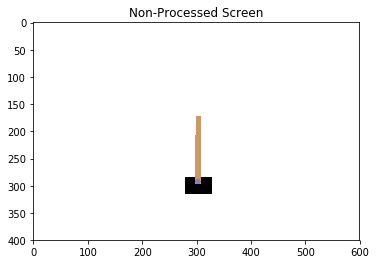

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
em = CartPoleEnvManager(device)
em.reset()
screen = em.render('rgb_array')

plt.figure()
plt.imshow(screen)
plt.title('Non-Processed Screen')
plt.show()

In [16]:
import numpy as np

# Example of Processed Screen

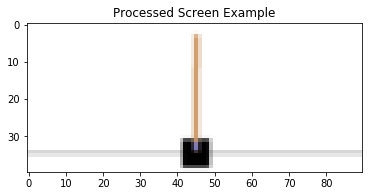

In [17]:
screen = em.get_processed_screen()
plt.figure()
plt.imshow(screen.squeeze(0).permute(1, 2, 0), interpolation = 'none')
plt.title('Processed Screen Example')
plt.show()

# Plot

In [24]:
def plot(values, moving_avg_period):
    plt.figure(2)
    plt.clf()
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(values)
    plt.plot(get_moving_average(moving_avg_period, values))
    plt.pause(0.001)
    
    if is_ipython: display.clear_output(wait = True)
        
def get_moving_average(period, values):
    values = torch.tensor(values, dtype = torch.float)
    if len(values) >= period:
        moving_avg = values.unfold(dimension = 0, size = period, step = 1).mean(dim = 1).flatten(start_dim = 0)
        moving_avg = torch.cat((torch.zeros(period - 1), moving_avg))
        return moving_avg.numpy()
    
    else:
        moving_avg = torch.zeros(len(values))
        return moving_avg.numpy()

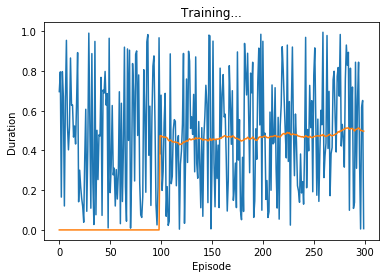

In [25]:
plot(np.random.rand(300), 100)

# Main Program

In [29]:
batch_size = 256
gamma = 0.999
eps_start = 1
eps_end = 0.01
eps_decay = 0.001
target_update = 10
memory_size = 100000
lr = 0.001
num_episodes = 1000


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
em = CartPoleEnvManager(device)
strategy = EpsilonGreedyStrategy(eps_start, eps_end, eps_decay)
agent = Agent(strategy, em.num_actions_available(), device)
memory = ReplayMemory(memory_size)


policy_net = DQN(em.get_screen_height(), em.get_screen_width()).to(device)
target_net = DQN(em.get_screen_height(), em.get_screen_width()).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()
optimizer = optim.Adam(params = policy_net.parameters(), lr = lr)


#Training
episode_durations = []
for episode in range(num_episodes):
    em.reset()
    state = em.get_state()
    
    for timestamp in count():
        action = agent.select_action(state, policy_net)
        reward = em.take_action(action)
        next_state = em.get_state()
        memory.push(Experience(state, action, reward, next_state))
        state = next_state
        
        if memory.can_provide_sample(batch_size):
            experiences = memory.sample(batch_size)
            state, action, reward, next_state = extract_tensors(experiences)
            
            current_q_values = QValues.get_current(policy_net, states, actions)
            next_q_values = QValues.get_next(target_net, next_states)
            target_q_values = (next_q_values * gamma) + rewards
            
            loss = F.mse_loss(current_q_values, target_q_values.unsqueeze(1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        if em.done:
            episode_durations.append(timestamp)
            plot(episode_durations, 100)
            break
            
    if episode % target_update == 0 :
        target_net.load_state_dict(policy_net.state_dict())
        
em.close()
        


TypeError: __init__() takes 3 positional arguments but 4 were given